In [1]:
import re
import sys
import inspect
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from matplotlib import font_manager, rcParams
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [2]:
# config取得
base_dir = Path.cwd().parent.parent
config_path = base_dir / "config"
sys.path.append(str(config_path))
from config import (RANDOM_SEED)

In [3]:
# 日本語フォント設定（見つかったものを使う）
jp_font_candidates = [
    "MS Gothic", "BIZ UDGothic", "Yu Gothic", "Meiryo",
    "Noto Sans CJK JP", "Noto Sans JP", "IPAexGothic"
]
available = set(f.name for f in font_manager.fontManager.ttflist)
use_font = None
for f in jp_font_candidates:
    if f in available:
        use_font = f
        break
if use_font:
    rcParams["font.family"] = use_font
rcParams["axes.unicode_minus"] = False  # マイナス記号の文字化け対策

# 読み込み 
common_dir = base_dir / "assets" / "csv_data"
input_path  = common_dir / "八王子霊園_葉音・VARI・座標結合済み.csv"
df = pd.read_csv(input_path)

c:\Users\kyous\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kyous\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== ロジスティック回帰（前処理込み） ===
Accuracy: 0.948  |  Macro-F1: 0.937
              precision    recall  f1-score   support

          健康      0.960     0.994     0.976       167
          危険      0.962     0.850     0.903        60
         要注意      0.928     0.934     0.931       137

    accuracy                          0.948       364
   macro avg      0.950     0.926     0.937       364
weighted avg      0.948     0.948     0.947       364

混同行列 (rows=true, cols=pred):
 [[166   1   0]
 [  7 128   2]
 [  0   9  51]]


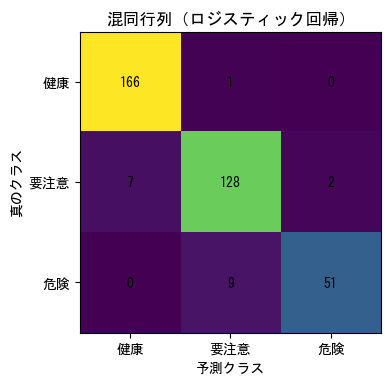

In [4]:
# 特徴量定義 
num_cols = [
    '緯度',
    '経度',
    'VARI',
    'VARI_mean',
    'VARI_std',
    'VARI_min',
    'VARI_max',
    'R_med',
    'G_med',
    'B_med',
    'R_mean',
    'G_mean',
    'B_mean',
    'veg_ratio',
    'n_mask',
    'n_veg',
    # 'leaf_temp_mean',
    # 'leaf_temp_min',
    # 'leaf_temp_max',
    # 'leaf_temp_median',
    # 'leaf_temp_std'
]
cat_cols = ['park_name']

# ラベル前処理 
df = df[df["class"].isin(["健康","要注意","危険"])].copy() 
# df = df.dropna(subset=(num_cols + cat_cols + ["class"])).reset_index(drop=True)  # 欠損は削除

# 入出力作成 
X = df[num_cols + cat_cols]
y = df["class"].to_numpy()

# 学習/評価分割 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_SEED
)

# 前処理 + ロジスティック回帰
ohe_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(**ohe_kwargs), cat_cols)
    ],
    remainder="drop"
)

pipe_lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        multi_class="ovr",
        max_iter=2000,
        random_state=RANDOM_SEED,
        C=0.7,
        penalty="l1",
        # solver="lbfgs", # ← l2対応のsolver
        solver="saga"   # ← l1対応のsolver
    ))
])

# 学習
pipe_lr.fit(X_train, y_train)

# 評価
def eval_model(name, model):
    y_pred = model.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}  |  Macro-F1: {f1m:.3f}")
    print(classification_report(y_test, y_pred, digits=3))
    label_order = ["健康","要注意","危険"]
    cm = confusion_matrix(y_test, y_pred, labels=label_order)
    print("混同行列 (rows=true, cols=pred):\n", cm)
    return y_pred, cm, label_order

y_pred_lr, cm_lr, labels_lr = eval_model("ロジスティック回帰（前処理込み）", pipe_lr)

# # 交差検証
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# cv_lr = cross_val_score(pipe_lr, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
# print(f"\nCV Macro-F1 (LR): mean={cv_lr.mean():.3f} ± {cv_lr.std():.3f}")

# 混同行列の可視化 
def plot_cm(cm, labels, title="混同行列"):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm)
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels)
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    ax.set_xlabel("予測クラス"); ax.set_ylabel("真のクラス")
    ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

plot_cm(cm_lr, labels_lr, title="混同行列（ロジスティック回帰）")


[クラス別 重要度上位（|coef|）Top10]


,class,feature_out,coef,abs_coef
2,健康,num__VARI,18.117497,18.117497
7,健康,num__R_med,-0.914767,0.914767
9,健康,num__B_med,-0.528329,0.528329
12,健康,num__B_mean,-0.297262,0.297262
5,健康,num__VARI_min,0.224388,0.224388
4,健康,num__VARI_std,-0.201912,0.201912
0,健康,num__緯度,0.130102,0.130102
14,健康,num__n_mask,-0.127972,0.127972
1,健康,num__経度,-0.022459,0.022459
13,健康,num__veg_ratio,0.017977,0.017977


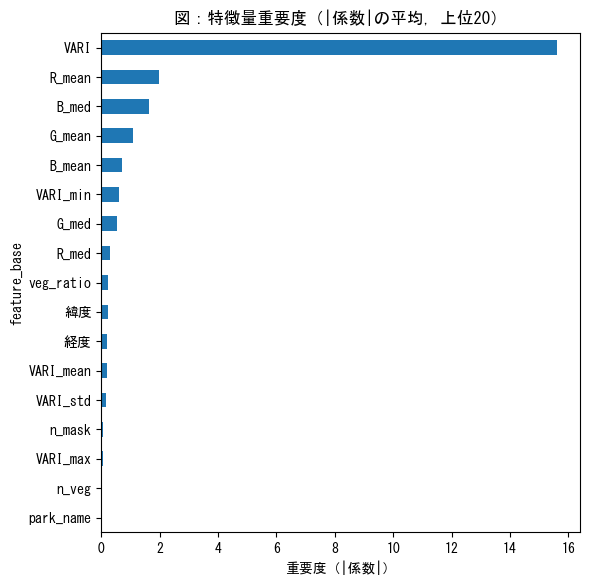

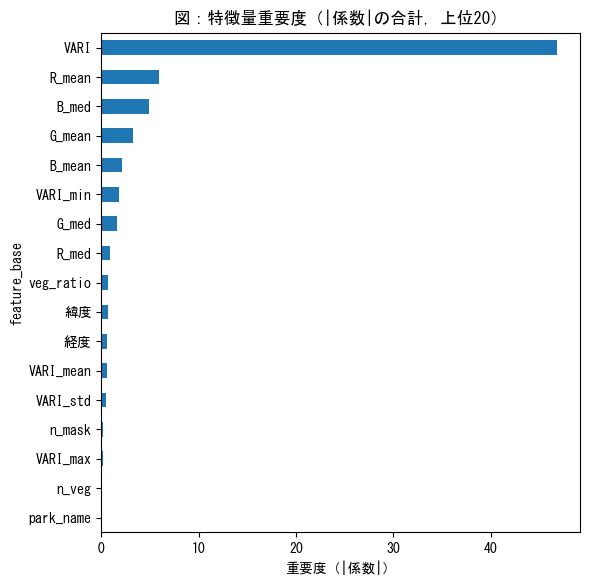

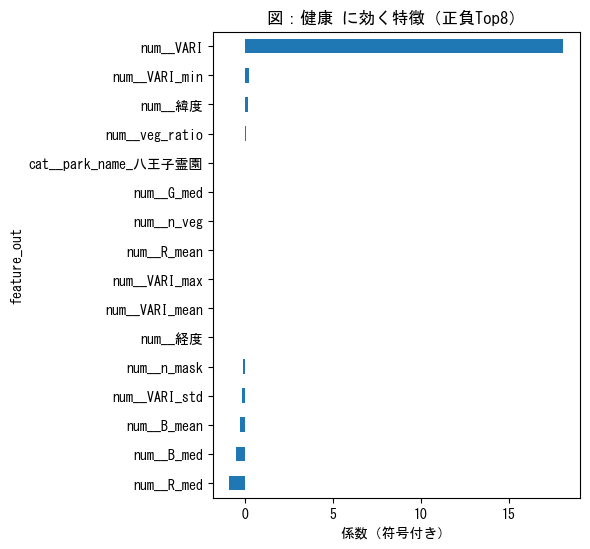

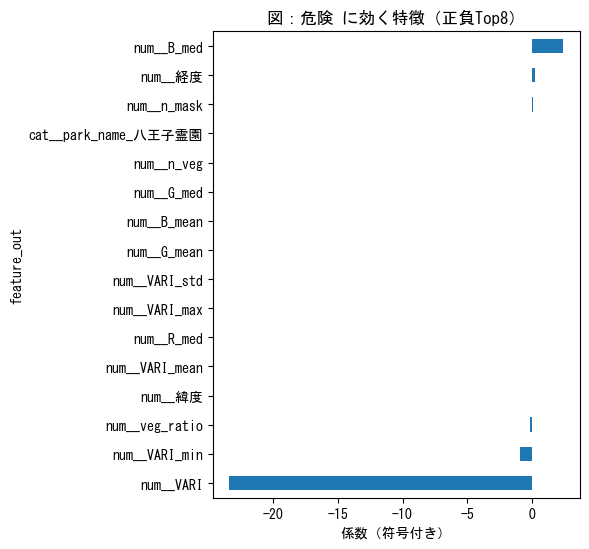

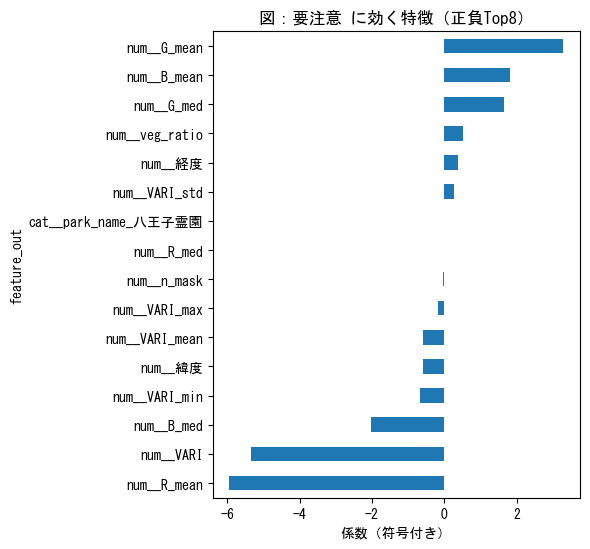

In [5]:
# 重要度（係数）可視化 

# 前処理と分類器を取得
prep = pipe_lr.named_steps["prep"]
clf  = pipe_lr.named_steps["clf"]

# 最終特徴名を取得
try:
    feat_names = prep.get_feature_names_out()
except Exception:
    # フォールバック：数値名 + OHE名を手組み
    feat_names = []
    # 数値カラム
    feat_names += [f"num__{c}" for c in num_cols]
    # カテゴリ（OneHotEncoder から）
    enc = prep.named_transformers_["cat"]
    try:
        cats = enc.get_feature_names_out(cat_cols)
    except Exception:
        cats = []
        for col_name, cats_list in zip(cat_cols, enc.categories_):
            cats += [f"cat__{col_name}_{c}" for c in cats_list]
    feat_names += list(cats)
feat_names = np.array(feat_names)

# 係数行列をDataFrame化（クラス別）
classes = clf.classes_         # 例: ["健康","危険","要注意"] の順
coefs = clf.coef_              # shape=(n_classes, n_features)

rows = []
for ci, cname in enumerate(classes):
    for fi, fname in enumerate(feat_names):
        coef = coefs[ci, fi]
        rows.append({
            "class": cname,
            "feature_out": fname,
            "coef": float(coef),
            "abs_coef": float(abs(coef))
        })
coef_df = pd.DataFrame(rows).sort_values(["class","abs_coef"], ascending=[True, False])

print("\n[クラス別 重要度上位（|coef|）Top10]")
display(coef_df.groupby("class").head(10))

# OHE水準を元列に集約して“特徴量単位”の重要度にする
def base_name(s: str) -> str:
    s = re.sub(r"^num__", "", s)
    s = re.sub(r"^cat__", "", s)
    # OHE水準（例: park_name_○○）は元列名に丸める
    for col in cat_cols:
        if s.startswith(col + "_"):
            return col
    return s

coef_df["feature_base"] = coef_df["feature_out"].map(base_name)

# 集約指標（平均/合計）を用意
agg_mean = (coef_df.groupby("feature_base")["abs_coef"]
            .mean().sort_values(ascending=False))
agg_sum  = (coef_df.groupby("feature_base")["abs_coef"]
            .sum().sort_values(ascending=False))

topN = 20

# 可視化関数
def plot_barh(series, title):
    plt.figure(figsize=(6, max(3, len(series.head(topN))*0.35)))
    series.head(topN).iloc[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel("重要度（|係数|）")
    plt.tight_layout()
    plt.show()

plot_barh(agg_mean, "図：特徴量重要度（|係数|の平均, 上位20）")
plot_barh(agg_sum,  "図：特徴量重要度（|係数|の合計, 上位20）")

# 参考：クラス別に“正/負”の強い特徴を確認
def plot_top_pos_neg_for_class(target_class, k=8):
    sub = coef_df[coef_df["class"]==target_class].copy().sort_values("coef")
    neg = sub.head(k)     # そのクラスを避ける方向の特徴
    pos = sub.tail(k)     # そのクラスに向かう方向の特徴
    both = pd.concat([neg, pos])
    plt.figure(figsize=(6, max(3, len(both)*0.35)))
    both.set_index("feature_out")["coef"].plot(kind="barh")
    plt.title(f"図：{target_class} に効く特徴（正負Top{k}）")
    plt.xlabel("係数（符号付き）")
    plt.tight_layout()
    plt.show()

for c in classes:
    plot_top_pos_neg_for_class(c, k=8)
